# Disruption flat-top labelling using a standard deviation based wobbliness check

Code to download just the summary from CSD3.

```bash
for i in {30001..30472}; do                                         
  rsync -avz --progress CSD3:/rds/project/rds-mOlK9qn0PlQ/fairmast/upload-tmp/level2/${i}.zarr/summary/ ~/Downloads/level2_summary/${i}/
done
```

In [57]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter, find_peaks
from scipy.interpolate import interp1d
import pandas as pd
import matplotlib.pyplot as plt

In [58]:
# ds = xr.open_zarr('level2_copy/30019', consolidated=False)

# # Plot ip vs time
# ds['ip'].plot()

In [59]:
shot_ids = [30108, 30121, 30178, 30035, 30183, 30086, 30112, 30109, 30209]

In [60]:
def detect_change_points(time, intensity, window_size=50, threshold=2.0):
    """
    Detects change points based on the difference in moving average intensity.

    Args:
    - time (np.array): Time array.
    - intensity (np.array): Intensity array.
    In level 1 data, plasma current is in kA, in level 2 data it is in Amps. So, we divide by 1000 to get kA.
    Otherwise, the gradient will be too high.
    - window_size (int): Size of the window for calculating moving average.
    - threshold (float): Threshold for detecting significant changes.

    Returns:
    - change_points (list): List of times when significant changes are detected.
    """
    moving_avg = np.convolve(intensity/1000, np.ones(window_size) / window_size, mode='valid')
    diff = np.abs(np.diff(moving_avg))

    change_indices = np.where(diff > threshold)[0] + window_size  # Adjust index for valid region
    change_points = time[change_indices]

    # If no change points detected, return None
    if len(change_points) == 0:
        return None

    return change_points

In [61]:
class DisruptionDetector:
    def __init__(
        self,
        ip_threshold=60.0,
        disruption_window=0.05,
        disruption_window_size=20,
        disruption_poly_order=2,
        disruption_prominence=10.0,
        flat_top_window_size=51,
        flat_top_tolerance=0.01,
        flat_top_interp_kind="linear",
        plot=False
    ):
        # disruption detection
        self.ip_threshold = ip_threshold
        self.disruption_window = disruption_window
        self.disruption_window_size = disruption_window_size
        self.disruption_poly_order = disruption_poly_order
        self.disruption_prominence = disruption_prominence

        # flat top
        self.flat_top_window_size = flat_top_window_size
        self.flat_top_tolerance = flat_top_tolerance
        self.flat_top_interp_kind = flat_top_interp_kind

        self.plot = plot

    def _detect_flattop_old(self, ip, time):
        try:
            interp_func = interp1d(time, ip, kind=self.flat_top_interp_kind)
            time_ds = np.linspace(time.min(), time.max(), self.flat_top_window_size, endpoint=False)
            smooth_ip = interp_func(time_ds)
            grad = np.gradient(smooth_ip, time_ds)

            # flat_idxs = np.where(np.abs(grad) < self.flat_top_tolerance * 1e5)[0] # # current is never flat enough for the tolerance.
            ## More relaxed threshold
            threshold = self.flat_top_tolerance * np.max(np.abs(ip))
            flat_idxs = np.where(np.abs(grad) < threshold)[0]

            print(f"DEBUG: flat_idxs count = {len(flat_idxs)}") 

            if len(flat_idxs) == 0:
                return np.nan, np.nan

            tmin = time_ds[flat_idxs.min()]
            tmax = time_ds[flat_idxs.max()]
            return tmin, tmax
        except Exception:
            return np.nan, np.nan
    def _detect_flattop(self, ip, time, td=None):
        """
        Detects the flat-top region of the plasma current using standard deviation based wobbliness check.
        """

        try:
            # Only search before disruption (if given), to avoid false flat region after crash
            # we use masking becasue standard deviation detects post disruption as a flat top.
            if td is None:
                print("td is none. can't mask post disruption zone.")
            if td is not None:
                mask = time < td
                ip = ip[mask]
                time = time[mask]

            # Compute rolling standard deviation to find "flat" regions
            window_pts = self.flat_top_window_size
            ip_series = pd.Series(ip)
            rolling_std = ip_series.rolling(window_pts, center=True).std()

            # Identify indices where the std is below threshold (i.e., flat)
            flat_idxs = np.where(rolling_std < self.flat_top_tolerance)[0]
            print(f"DEBUG: flat_idxs count = {len(flat_idxs)}")

            if len(flat_idxs) == 0:
                return np.nan, np.nan

            # Split into continuous segments
            diffs = np.diff(flat_idxs)
            split_idx = np.where(diffs > 1)[0]
            segments = np.split(flat_idxs, split_idx + 1)

            # Pick the longest continuous flat segment
            longest = max(segments, key=len)

            # Extract start and end times
            tmin = time[longest[0]]
            tmax = time[longest[-1]]
            return tmin, tmax

        except Exception as e:
            print(f"Flat-top detection failed: {e}")
            return np.nan, np.nan
    
    def _detect_rampup(self, flat_top_start):
        return 0.0, flat_top_start

    def run(self, shot, ip, time):
        # remove early garbage
        mask = time >= 0
        ip = ip[mask]
        time = time[mask]

        change_points = detect_change_points(time, ip, window_size=self.disruption_window_size, threshold=self.disruption_prominence)

        if change_points is None or len(change_points) == 0:
            print(f"Shot {shot}: No disruption change point detected.")
            td = np.nan
        else:
            td = change_points[-1]  # last strong drop = most likely crash
        ft_start, ft_end = self._detect_flattop(ip, time, td)
        ru_start, ru_end = self._detect_rampup(ft_start)

        return {
            "shot": shot,
            "td": td,
            "flattop_start": ft_start,
            "flattop_end": ft_end,
            "rampup_start": ru_start,
            "rampup_end": ru_end,
        }

In [62]:
# # default values
# params = {
#     "ip_threshold": 60.0,
#     "disruption_window": 0.05,
#     "disruption_window_size": 20,
#     "disruption_poly_order": 2,
#     "disruption_prominence": 10,
#     "flat_top_window_size": 51,
#     "flat_top_tolerance": 0.01,
#     "flat_top_interp_kind": "linear",
# }

In [63]:
# larger window and threshold for standard deviation based flatness check
params = {
    "ip_threshold": 60.0,
    "disruption_window": 0.05,
    "disruption_window_size": 20,
    "disruption_poly_order": 2,
    "disruption_prominence": 10,
    "flat_top_window_size": 100,
    "flat_top_tolerance": 10000,
    "flat_top_interp_kind": "linear",
}

In [64]:
# # Tighter flat-top detection
# params = {
#     "ip_threshold": 100.0,
#     "disruption_window": 0.06,
#     "disruption_window_size": 30,
#     "disruption_poly_order": 3,
#     "disruption_prominence": 2000.0,
#     "flat_top_window_size": 150,
#     "flat_top_tolerance": 0.005,
#     "flat_top_interp_kind": "cubic",
# }


In [65]:
# # Relaxed gradient 
# params = {
#     "ip_threshold": 80.0,
#     "disruption_window": 0.05,
#     "disruption_window_size": 20,
#     "disruption_poly_order": 2,
#     "disruption_prominence": 10000.0,
#     "flat_top_window_size": 100,
#     "flat_top_tolerance": 0.02,
#     "flat_top_interp_kind": "linear",
# }


In [66]:
results = []

for shot in shot_ids:
    ds = xr.open_zarr(f"./level2_copy/{shot}", consolidated=False)
    ip = ds["ip"].values
    time = ds["time"].values

    detector = DisruptionDetector(**params)
    result = detector.run(shot, ip, time)
    results.append(result)
    

df = pd.DataFrame(results)


DEBUG: flat_idxs count = 466
DEBUG: flat_idxs count = 904
DEBUG: flat_idxs count = 1027
DEBUG: flat_idxs count = 113
DEBUG: flat_idxs count = 851
DEBUG: flat_idxs count = 1719
DEBUG: flat_idxs count = 720
DEBUG: flat_idxs count = 469
DEBUG: flat_idxs count = 1289


In [67]:
df

,shot,td,flattop_start,flattop_end,rampup_start,rampup_end
0,30108,0.34795,0.20895,0.32520,0.0,0.20895
1,30121,0.38955,0.22530,0.35430,0.0,0.22530
2,30178,0.52945,0.12970,0.38620,0.0,0.12970
3,30035,0.21515,0.13165,0.14565,0.0,0.13165
4,30183,0.42520,0.12770,0.33220,0.0,0.12770
5,30086,0.53920,0.09095,0.52045,0.0,0.09095
6,30112,0.36930,0.16780,0.34755,0.0,0.16780
7,30109,0.34830,0.20880,0.32580,0.0,0.20880
8,30209,0.54015,0.12990,0.45190,0.0,0.12990


In [68]:
def plot_single_shot(shot_id, ip, time, labels_dict):
    colors = ['red', 'blue', 'green', 'orange', 'purple']
    label_names = ['rampup_start', 'rampup_end', 'flattop_start', 'flattop_end', 'td']

    plt.figure(figsize=(10, 4))
    plt.plot(time, ip)#, label="ip(t)")

    for i, label in enumerate(label_names):
        val = labels_dict.get(label, np.nan)
        if not np.isnan(val):
            plt.axvline(x=val, color=colors[i], linestyle='--', label=f"{label}={val:.3f}")
        else:
            plt.axvline(x=time[0], color=colors[i], linestyle=':', label=f"{label}=nan")

    plt.xlabel("Time (s)")
    plt.ylabel("Plasma Current")
    plt.title(f"Shot {shot_id}")
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    plt.tight_layout()


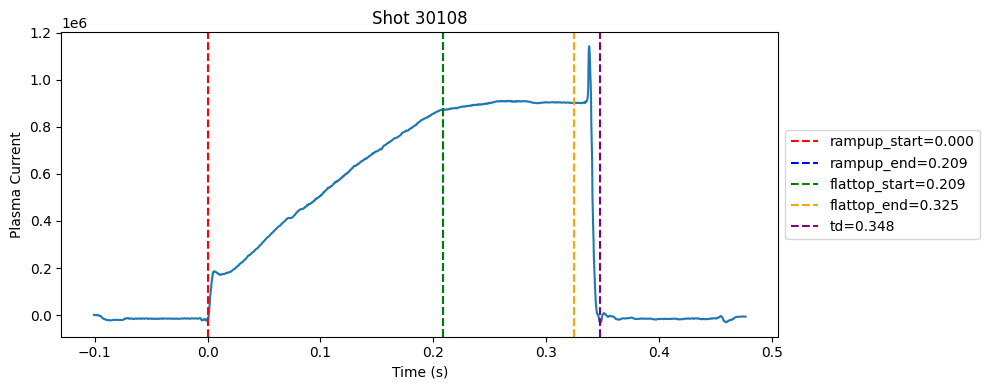

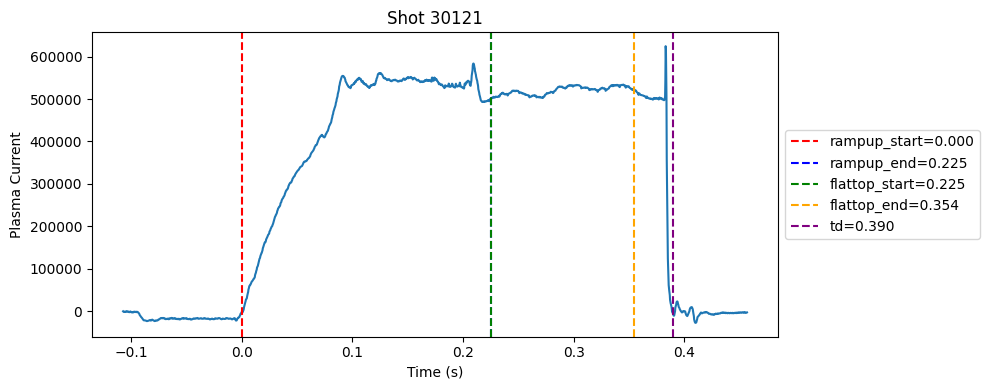

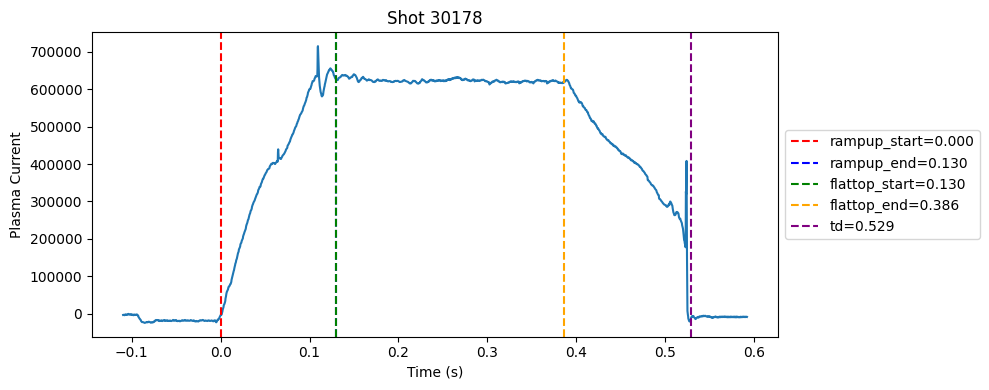

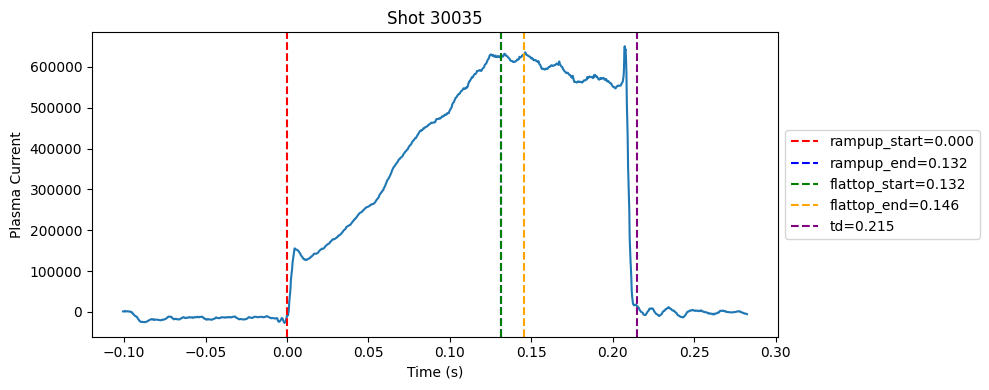

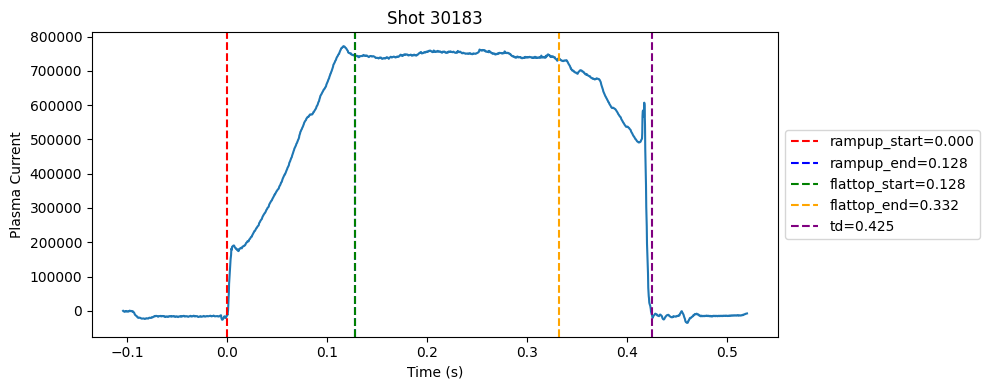

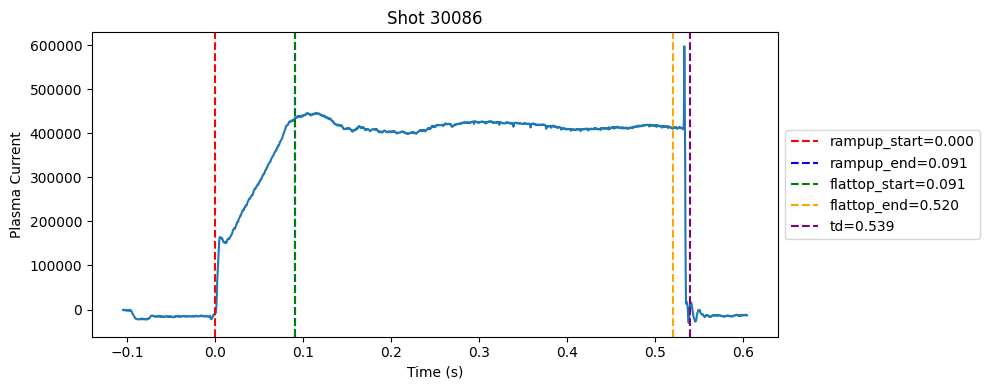

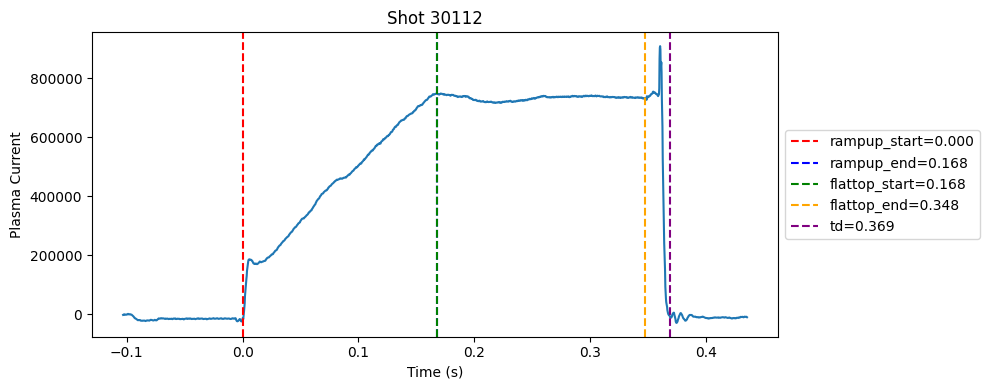

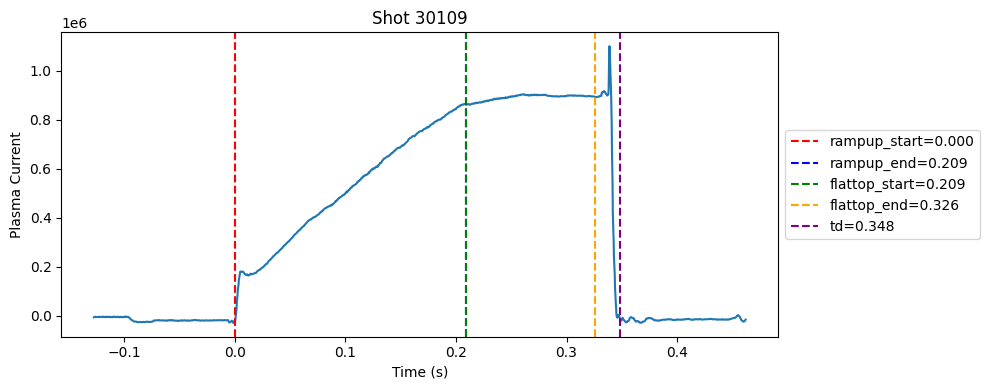

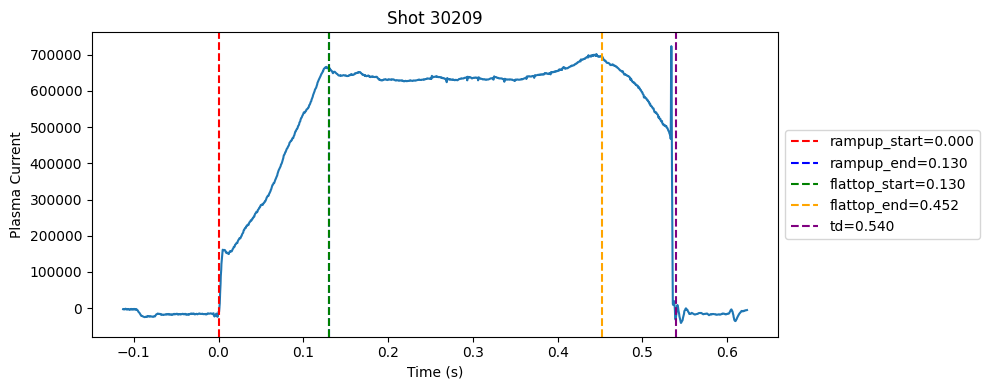

In [69]:
for result in results:
    shot_id = result["shot"]
    ds = xr.open_zarr(f"./level2_copy/{shot_id}", consolidated=False)
    ip = ds["ip"].values
    time = ds["time"].values

    plot_single_shot(shot_id, ip, time, result)